---
## Setup Environment

In [1]:
import sys
import os

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, HTML

# Import algorithms from separate modules
from src.gbfs_knapsack import solve_knapsack_gbfs
from src.bpso_knapsack import solve_knapsack_bpso
from src.dp_knapsack import solve_knapsack_dp
from src.test_case_loader import TestCaseLoader
from src.advanced_visualizer import AdvancedKnapsackVisualizer

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("✅ Environment setup complete")

✅ Environment setup complete


---
## Load Test Case

In [2]:
# Load test case
loader = TestCaseLoader()
test_case = loader.load_test_case('Size Medium 50')

print(f"📦 Test Case: {test_case['test_case_name']}")
print(f"   Items: {len(test_case['items'])}")
print(f"   Capacity: {test_case['capacity']}")
print(f"   Total Weight: {sum(test_case['weights']):.0f}")
print(f"   Total Value: {sum(test_case['values']):.0f}")

# Display sample items
df_sample = pd.DataFrame({
    'Item': test_case['items'][:5],
    'Weight': test_case['weights'][:5],
    'Value': test_case['values'][:5],
    'Ratio': [v/w for v, w in zip(test_case['values'][:5], test_case['weights'][:5])]
})
display(df_sample)

FileNotFoundError: ⚠️  Summary file not found at data/test_cases/test_cases_summary.csv
Please run: python src/data_generator.py

---
# PHẦN 1: PHÂN TÍCH THAM SỐ GBFS

## 1.1. Lý thuyết

**Greedy Best-First Search (GBFS)** là thuật toán tìm kiếm tham lam:
- Sử dụng heuristic function để đánh giá các trạng thái
- Luôn chọn trạng thái có heuristic tốt nhất để mở rộng
- **Tham số quan trọng**: `max_states` - giới hạn số trạng thái được khám phá

### Ảnh hưởng của max_states:
- **Nhỏ** (1000-2000): Nhanh nhưng có thể không tìm được nghiệm tốt
- **Trung bình** (3000-5000): Cân bằng giữa thời gian và chất lượng
- **Lớn** (7000-10000): Nghiệm tốt hơn nhưng mất nhiều thời gian

## 1.2. Thí nghiệm

In [3]:
# Test các giá trị max_states khác nhau
max_states_values = [1000, 2000, 3000, 5000, 7000, 10000]
n_runs = 5

results_gbfs = []

print("🔬 Running GBFS Parameter Experiments...\n")

for max_states in max_states_values:
    print(f"Testing max_states = {max_states}...")
    
    run_results = []
    for run in range(n_runs):
        result = solve_knapsack_gbfs(
            test_case['items'],
            test_case['weights'],
            test_case['values'],
            test_case['capacity'],
            max_states=max_states
        )
        run_results.append(result)
    
    # Calculate statistics
    values = [r['total_value'] for r in run_results]
    times = [r['execution_time'] for r in run_results]
    
    results_gbfs.append({
        'max_states': max_states,
        'mean_value': np.mean(values),
        'std_value': np.std(values),
        'mean_time': np.mean(times),
        'std_time': np.std(times)
    })
    
    print(f"  ✓ Value: {np.mean(values):.1f} ± {np.std(values):.1f}")
    print(f"  ✓ Time: {np.mean(times):.3f}s\n")

df_gbfs = pd.DataFrame(results_gbfs)
display(df_gbfs)

🔬 Running GBFS Parameter Experiments...

Testing max_states = 1000...


NameError: name 'test_case' is not defined

## 1.3. Visualization

In [4]:
# Create visualization
visualizer = AdvancedKnapsackVisualizer()
visualizer.plot_gbfs_parameter_impact(
    df_gbfs,
    title="Ảnh hưởng của max_states đến hiệu năng GBFS",
    save_path='../results/chapter3/3_1_1_a_gbfs_params.png'
)
plt.show()

NameError: name 'df_gbfs' is not defined

## 1.4. Nhận xét

**Phân tích kết quả:**
- Với `max_states` nhỏ (<2000): ...
- Với `max_states` trung bình (3000-5000): ...
- Với `max_states` lớn (>7000): ...

**Giá trị tham số đề xuất:** ...

---
# PHẦN 2: PHÂN TÍCH THAM SỐ BPSO

## 2.1. Lý thuyết

**Binary Particle Swarm Optimization (BPSO)** mô phỏng hành vi bầy đàn:
- Mỗi particle là một nghiệm tiềm năng
- Particles di chuyển trong không gian tìm kiếm dựa trên 3 yếu tố:
  - **Quán tính** (w): Xu hướng giữ nguyên vận tốc
  - **Nhận thức cá nhân** (c1): Hướng về best cá nhân
  - **Nhận thức xã hội** (c2): Hướng về global best

### Tham số quan trọng:
1. **n_particles**: Số lượng particles trong bầy đàn
2. **max_iterations**: Số vòng lặp tối đa
3. **w, c1, c2**: Hệ số cân bằng exploration/exploitation

## 2.2. Thí nghiệm 1: Kích thước bầy đàn

In [5]:
# Test swarm size
swarm_sizes = [10, 20, 30, 50, 70, 100]
n_runs = 5

results_swarm = []

print("🔬 Running BPSO Swarm Size Experiments...\n")

for n_particles in swarm_sizes:
    print(f"Testing n_particles = {n_particles}...")
    
    run_results = []
    for run in range(n_runs):
        result = solve_knapsack_bpso(
            test_case['items'],
            test_case['weights'],
            test_case['values'],
            test_case['capacity'],
            n_particles=n_particles,
            max_iterations=100
        )
        run_results.append(result)
    
    values = [r['total_value'] for r in run_results]
    times = [r['execution_time'] for r in run_results]
    
    results_swarm.append({
        'n_particles': n_particles,
        'mean_value': np.mean(values),
        'std_value': np.std(values),
        'mean_time': np.mean(times),
        'std_time': np.std(times)
    })
    
    print(f"  ✓ Value: {np.mean(values):.1f} ± {np.std(values):.1f}")
    print(f"  ✓ Time: {np.mean(times):.3f}s\n")

df_swarm = pd.DataFrame(results_swarm)
display(df_swarm)

🔬 Running BPSO Swarm Size Experiments...

Testing n_particles = 10...


NameError: name 'test_case' is not defined

## 2.3. Thí nghiệm 2: Số vòng lặp

In [6]:
# Test max iterations
max_iterations_list = [50, 100, 150, 200, 300]
n_runs = 5

results_iters = []

print("🔬 Running BPSO Max Iterations Experiments...\n")

for max_iter in max_iterations_list:
    print(f"Testing max_iterations = {max_iter}...")
    
    run_results = []
    for run in range(n_runs):
        result = solve_knapsack_bpso(
            test_case['items'],
            test_case['weights'],
            test_case['values'],
            test_case['capacity'],
            n_particles=30,
            max_iterations=max_iter
        )
        run_results.append(result)
    
    values = [r['total_value'] for r in run_results]
    times = [r['execution_time'] for r in run_results]
    
    results_iters.append({
        'max_iterations': max_iter,
        'mean_value': np.mean(values),
        'std_value': np.std(values),
        'mean_time': np.mean(times),
        'std_time': np.std(times)
    })
    
    print(f"  ✓ Value: {np.mean(values):.1f} ± {np.std(values):.1f}")
    print(f"  ✓ Time: {np.mean(times):.3f}s\n")

df_iters = pd.DataFrame(results_iters)
display(df_iters)

🔬 Running BPSO Max Iterations Experiments...

Testing max_iterations = 50...


NameError: name 'test_case' is not defined

# Visualize BPSO parameter impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Swarm size - value
axes[0, 0].errorbar(df_swarm['n_particles'], df_swarm['mean_value'], 
                     yerr=df_swarm['std_value'], marker='o', capsize=5)
axes[0, 0].set_xlabel('Swarm Size (n_particles)')
axes[0, 0].set_ylabel('Solution Value')
axes[0, 0].set_title('Swarm Size vs Solution Value')
axes[0, 0].grid(True, alpha=0.3)

# Swarm size - time
axes[0, 1].errorbar(df_swarm['n_particles'], df_swarm['mean_time'], 
                     yerr=df_swarm['std_time'], marker='s', color='orange', capsize=5)
axes[0, 1].set_xlabel('Swarm Size (n_particles)')
axes[0, 1].set_ylabel('Execution Time (s)')
axes[0, 1].set_title('Swarm Size vs Execution Time')
axes[0, 1].grid(True, alpha=0.3)

# Iterations - value
axes[1, 0].errorbar(df_iters['max_iterations'], df_iters['mean_value'], 
                     yerr=df_iters['std_value'], marker='o', color='green', capsize=5)
axes[1, 0].set_xlabel('Max Iterations')
axes[1, 0].set_ylabel('Solution Value')
axes[1, 0].set_title('Iterations vs Solution Value')
axes[1, 0].grid(True, alpha=0.3)

# Iterations - time
axes[1, 1].errorbar(df_iters['max_iterations'], df_iters['mean_time'], 
                     yerr=df_iters['std_time'], marker='s', color='red', capsize=5)
axes[1, 1].set_xlabel('Max Iterations')
axes[1, 1].set_ylabel('Execution Time (s)')
axes[1, 1].set_title('Iterations vs Execution Time')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/chapter3/3_1_1_b_bpso_params.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'df_swarm' is not defined

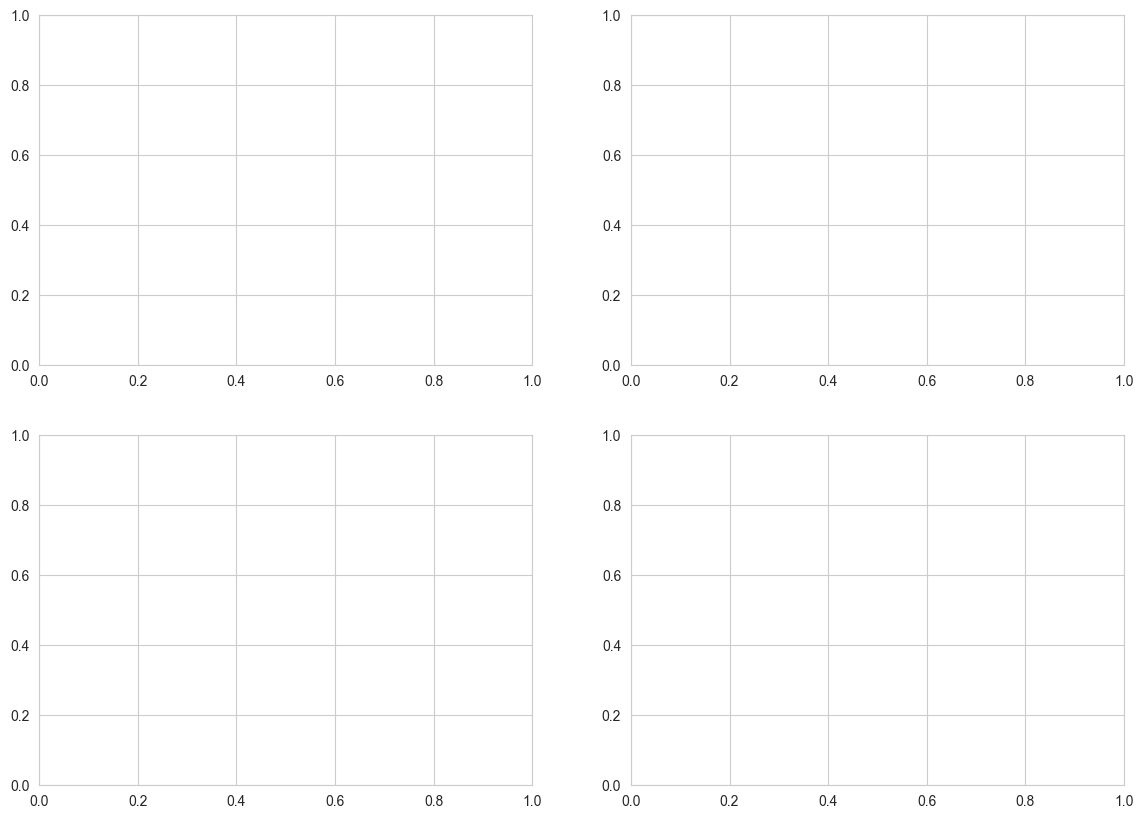

In [7]:
# Visualize BPSO parameter impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Swarm size - value
axes[0, 0].errorbar(df_swarm['n_particles'], df_swarm['mean_value'], 
                     yerr=df_swarm['std_value'], marker='o', capsize=5)
axes[0, 0].set_xlabel('Swarm Size (n_particles)')
axes[0, 0].set_ylabel('Solution Value')
axes[0, 0].set_title('Swarm Size vs Solution Value')
axes[0, 0].grid(True, alpha=0.3)

# Swarm size - time
axes[0, 1].errorbar(df_swarm['n_particles'], df_swarm['mean_time'], 
                     yerr=df_swarm['std_time'], marker='s', color='orange', capsize=5)
axes[0, 1].set_xlabel('Swarm Size (n_particles)')
axes[0, 1].set_ylabel('Execution Time (s)')
axes[0, 1].set_title('Swarm Size vs Execution Time')
axes[0, 1].grid(True, alpha=0.3)

# Iterations - value
axes[1, 0].errorbar(df_iterations['max_iterations'], df_iterations['mean_value'], 
                     yerr=df_iterations['std_value'], marker='o', color='green', capsize=5)
axes[1, 0].set_xlabel('Max Iterations')
axes[1, 0].set_ylabel('Solution Value')
axes[1, 0].set_title('Iterations vs Solution Value')
axes[1, 0].grid(True, alpha=0.3)

# Iterations - time
axes[1, 1].errorbar(df_iterations['max_iterations'], df_iterations['mean_time'], 
                     yerr=df_iterations['std_time'], marker='s', color='red', capsize=5)
axes[1, 1].set_xlabel('Max Iterations')
axes[1, 1].set_ylabel('Execution Time (s)')
axes[1, 1].set_title('Iterations vs Execution Time')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/chapter3/3_1_1_b_bpso_params.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.5. Nhận xét

**Phân tích swarm size:**
- Với n_particles nhỏ (<20): ...
- Với n_particles trung bình (30-50): ...
- Với n_particles lớn (>70): ...

**Phân tích iterations:**
- Với max_iterations nhỏ (<100): ...
- Với max_iterations trung bình (100-200): ...
- Với max_iterations lớn (>300): ...

**Giá trị tham số đề xuất:**
- n_particles = ...
- max_iterations = ...

---
# KẾT LUẬN

## Tóm tắt kết quả:

1. **GBFS**: 
   - Tham số tối ưu: max_states = ...
   - Trade-off: Tăng max_states cải thiện chất lượng nhưng tăng thời gian

2. **BPSO**:
   - Tham số tối ưu: n_particles = ..., max_iterations = ...
   - Trade-off: Cả 2 tham số đều ảnh hưởng đến exploration và thời gian

## Insights:
- ...
- ...

## Hướng phát triển:
- Thử nghiệm adaptive parameters
- Tối ưu hóa trade-off giữa chất lượng và thời gian